### A Fantasy Premier League (FPL) Predcition Model - Part 0

*Objective*: Predict the amount of points a player will score over the course of $n$ weeks 

*Input*: any information that can be scraped from the web - but I'm starting with [this](https://github.com/vaastav/Fantasy-Premier-League/) github repo 

--- 

**Initial Thoughts / Assumptions** 

- The way a player performs in week $n-1$ has an effect on his performance in week $n$ 
- The strength of a team a player is facing has an effect on his performance  


..... so to start out with, let's create a linear model using a players game week stats for the previous week to predict the amount of fantasy points he scores in the *next* week


we'll need these libraries 

In [157]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os

# for model building 
import xgboost as xgb 
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

The repo contains data for every game week from 2016-2020 - to start I'll train the first model on data *just* from last season (2019-2020) 

I'll bring them in and order them in a dictionary

In [44]:
weekly_data = {}
for week in range(1,48): 
    try:  
        data = pd.read_csv(f'../Fantasy-Premier-League/data/2019-20/gws/gw{week}.csv') 
        weekly_data[week] = data 
    except: 
        pass

In [45]:
weekly_engineered = {}
for wk in weekly_data: 
    if wk == 47: 
        pass 
    else: 
        df = pd.merge(weekly_data[wk], weekly_data[wk+1][['name', 'total_points']], on='name', how='inner')  
        home_dummy = pd.get_dummies(df['was_home'], prefix='home') 
        df = pd.concat([df, home_dummy], axis=1).drop(['was_home', 'kickoff_time'], axis=1) # dropping kickoff time 
        weekly_engineered[wk] = df

In [46]:
full_df = pd.concat([x[1] for x in list(weekly_engineered.items())], axis=0).reset_index(drop=True)

Underneath is just converting all data types to int or floats since a lot show up as objects

In [50]:
dtype_dict = full_df.dtypes.to_dict() 
data = {}
for col in dtype_dict: 
    if dtype_dict[col] == object: 
        if col in ['name', 'opponent_team']: 
            data[col] = full_df[col].values 
        else: 
            data[col] = [int(x) for x in full_df[col].values] 
    else: 
        # everything else is a float 
        data[col] = full_df[col].values 
        
data = pd.DataFrame(data)

In [141]:
print(f"{data.shape[0]} observations and {data.shape[1]} features")

21092 observations and 33 features


### Section 1 - Exploratory Data Analysis 

First, let's just look at the correlation matrix with all features

In [183]:
os.getcwd()

'/Users/gconybear/Documents/fantasy/notebooks'

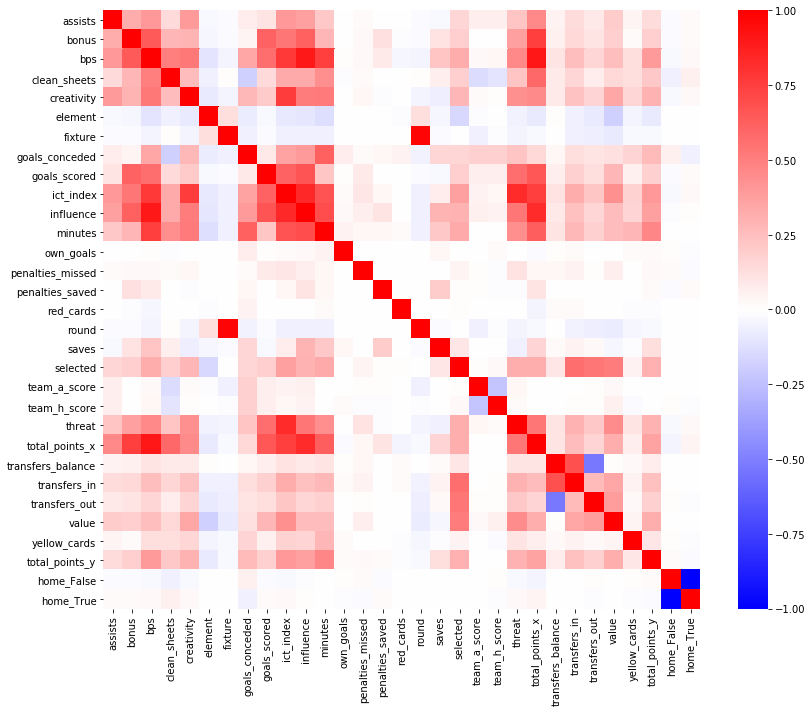

In [184]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=False, cmap='bwr') 
# plt.title('Correlation Matrix') 
plt.tight_layout() 
# plt.savefig('article_data/first/corr_matrix.png')
plt.show()

Since we're interested in total points next week (the variable called "total_points_y"), let's find the top correlations just for that feature

In [101]:
tp_corr = list(zip(data.corr()['total_points_y'].index, data.corr()['total_points_y'].values)) 
tp_corr = sorted(tp_corr, key=lambda x:abs(x[1]), reverse=True) 

print('Top 5 Correlations with Total Points Scored Next Week') 
print('--------\n') 
for (feature, corr) in tp_corr[1:6]:
    print(f"{feature} --> correlation val of {corr}")

Top 5 Correlations with Total Points Scored Next Week
--------

minutes --> correlation val of 0.4695364617009615
ict_index --> correlation val of 0.40072286374335503
bps --> correlation val of 0.3970822139054743
influence --> correlation val of 0.37309079798108574
total_points_x --> correlation val of 0.36480532290475237


minutes, ict index, bonus points, influence rating, and total points in the previous week have the highest correlations with points earned in the following week 

let's plot a couple scatter plots to better visualize these relationships

In [188]:
from pylab import text

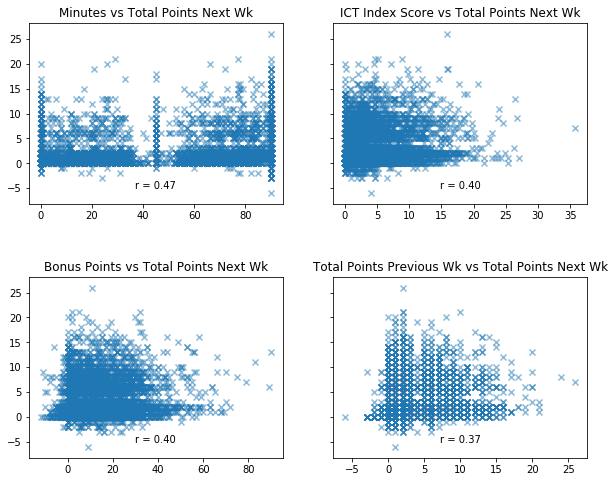

In [195]:
transparency = 0.5

fig, axs = plt.subplots(2,2, sharey=True, figsize=(10,8)) 
axs[0,0].scatter(data['minutes'].values, data['total_points_y'].values, alpha=transparency, marker='x')  
axs[0,0].set_title('Minutes vs Total Points Next Wk')  
text(0.5, 0.1,'r = 0.47', ha='center', va='center', transform=axs[0,0].transAxes)

axs[0,1].scatter(data['ict_index'].values, data['total_points_y'].values, alpha=transparency, marker='x')   
axs[0,1].set_title('ICT Index Score vs Total Points Next Wk')  
text(0.5, 0.1,'r = 0.40', ha='center', va='center', transform=axs[0,1].transAxes)

axs[1,0].scatter(data['bps'].values, data['total_points_y'].values, alpha=transparency, marker='x')   
axs[1,0].set_title('Bonus Points vs Total Points Next Wk')  
text(0.5, 0.1,'r = 0.40', ha='center', va='center', transform=axs[1,0].transAxes)

axs[1,1].scatter(data['total_points_x'].values, data['total_points_y'].values, alpha=transparency, marker='x')   
axs[1,1].set_title('Total Points Previous Wk vs Total Points Next Wk')  
text(0.5, 0.1,'r = 0.37', ha='center', va='center', transform=axs[1,1].transAxes)

plt.subplots_adjust(wspace=0.2, hspace=0.4) 
plt.savefig('article_data/first/scatter_plots.png')
plt.show()

### Section 2 - Modeling  

<ins>Model</ins>

This notebook will just focus on *linear* modeling - here we're imposing a bias and making an assumption that the target variable (total points next week) can be represented by some linear combination of the features (variables from the previous week)  

In future works, I'll remove this bias and try more complicated models with engineered features 

<ins>Baselines</ins> 

These need to be simple yet intuitive. We need these to compare the linear models to. I'll be using these two for now:

1. Next weeks points for player $i$ = previous weeks points for player $i$
2. Next weeks points for all players = average points

Next, I'll fit **Linear Regression**, **Lasso Regression** (L1 regularization), and **Ridge Regression** (L2 regularization) models to the data 

In [171]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['name', 'total_points_y'], axis=1), data['total_points_y'].values, 
                                                   test_size=0.33, random_state=42) 

lr = LinearRegression().fit(X_train, y_train) 
preds = lr.predict(X_test)  

# --- baselines --- 
last_wk_base = X_test['total_points_x'].values 
mean_base = np.repeat(y_train.mean(), len(y_test))

print('Model Error')
print('MSE: ', mean_squared_error(y_test, preds)) 
print('MAE: ', mean_absolute_error(y_test, preds), '\n')

print('Last Weeks Points - Baseline')
print('MSE: ', mean_squared_error(y_test, last_wk_base)) 
print('MAE: ', mean_absolute_error(y_test, last_wk_base), '\n')

print('Mean of Training Set - Baseline')
print('MSE: ', mean_squared_error(y_test, mean_base)) 
print('MAE: ', mean_absolute_error(y_test, mean_base), '\n')

feature_importances = list(zip(X_train.columns, lr.coef_)) 

def get_most_important_feats(fi_list, n): 
    """
    fi list: zipped list (feature, coef) 
    n: (int) how many features to display
    """  
    fi_abs = [(feat, abs(coef)) for (feat, coef) in fi_list]   
    topfeats = [feat for (feat, coef) in sorted(fi_abs, key=lambda x:x[1], reverse=True)][:n]  

    return sorted([(feat, coef) for (feat, coef) in fi_list if feat in topfeats], key=lambda x:abs(x[1]), reverse=True)


print('\nTop Features in Linear Regression Model')  
print('-----\n')   

c = 1
for (feat, val) in get_most_important_feats(feature_importances, 5): 
    print(f"{c}. {feat}, {round(val, 2)}") 
    c += 1


Model Error
MSE:  4.539979853234774
MAE:  1.2377129583000102
 
Last Weeks Points - Baseline
MSE:  7.814394483551214
MAE:  1.3702054302542739
 
Mean of Training Set - Baseline
MSE:  6.253716548846385
MAE:  1.6606389607145429
 

Top Features in Linear Regression Model
-----

1. red_cards, -0.94
2. penalties_missed, -0.66
3. penalties_saved, -0.51
4. clean_sheets, -0.35
5. own_goals, 0.22


In [172]:


lasso = Lasso().fit(X_train, y_train) 
preds = lasso.predict(X_test)  

# --- baselines --- 
last_wk_base = X_test['total_points_x'].values 
mean_base = np.repeat(y_train.mean(), len(y_test))

print('Model Error')
print('MSE: ', mean_squared_error(y_test, preds)) 
print('MAE: ', mean_absolute_error(y_test, preds), '\n')

print('Last Weeks Points - Baseline')
print('MSE: ', mean_squared_error(y_test, last_wk_base)) 
print('MAE: ', mean_absolute_error(y_test, last_wk_base), '\n')

print('Mean of Training Set - Baseline')
print('MSE: ', mean_squared_error(y_test, mean_base)) 
print('MAE: ', mean_absolute_error(y_test, mean_base), '\n')

feature_importances = list(zip(X_train.columns, lasso.coef_)) 

print('\nTop Features in Lasso Regression Model')  
print('-----\n')   

c = 1
for (feat, val) in get_most_important_feats(feature_importances, 5): 
    print(f"{c}. {feat}, {round(val, 5)}") 
    c += 1


Model Error
MSE:  4.589808095567862
MAE:  1.2568471700775343
 
Last Weeks Points - Baseline
MSE:  7.814394483551214
MAE:  1.3702054302542739
 
Mean of Training Set - Baseline
MSE:  6.253716548846385
MAE:  1.6606389607145429
 

Top Features in Lasso Regression Model
-----

1. minutes, 0.02359
2. value, 0.02217
3. influence, 0.00061
4. fixture, 0.00019
5. threat, 0.00016


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 611.79390262776, tolerance: 8.774517118392184
  model = cd_fast.enet_coordinate_descent(


In [174]:


ridge = Ridge().fit(X_train, y_train) 
preds = ridge.predict(X_test)  

# --- baselines --- 
last_wk_base = X_test['total_points_x'].values 
mean_base = np.repeat(y_train.mean(), len(y_test))

print('Model Error')
print('MSE: ', mean_squared_error(y_test, preds)) 
print('MAE: ', mean_absolute_error(y_test, preds), '\n')

print('Last Weeks Points - Baseline')
print('MSE: ', mean_squared_error(y_test, last_wk_base)) 
print('MAE: ', mean_absolute_error(y_test, last_wk_base), '\n')

print('Mean of Training Set - Baseline')
print('MSE: ', mean_squared_error(y_test, mean_base)) 
print('MAE: ', mean_absolute_error(y_test, mean_base), '\n')

feature_importances = list(zip(X_train.columns, ridge.coef_)) 

print('\nTop Features in Ridge Regression Model')  
print('-----\n')   

c = 1
for (feat, val) in get_most_important_feats(feature_importances, 5): 
    print(f"{c}. {feat}, {round(val, 2)}") 
    c += 1


Model Error
MSE:  4.54003501013059
MAE:  1.2377037878008308
 
Last Weeks Points - Baseline
MSE:  7.814394483551214
MAE:  1.3702054302542739
 
Mean of Training Set - Baseline
MSE:  6.253716548846385
MAE:  1.6606389607145429
 

Top Features in Ridge Regression Model
-----

1. red_cards, -0.91
2. penalties_missed, -0.6
3. penalties_saved, -0.48
4. clean_sheets, -0.35
5. own_goals, 0.22


**Insights** 

Vanilla Linear Regression seems to slighlty outperform other models 

In [159]:
topfeats = ['clean_sheets', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards'] 

lr_tf = LinearRegression().fit(X_train[topfeats], y_train) 
preds_tf = lr_tf.predict(X_test[topfeats])  

# --- baselines --- 
last_wk_base = X_test['total_points_x'].values 
mean_base = np.repeat(y_train.mean(), len(y_test))

print('Model Error')
print('MSE: ', mean_squared_error(y_test, preds_tf)) 
print('MAE: ', mean_absolute_error(y_test, preds_tf), '\n')

print('Last Weeks Points - Baseline')
print('MSE: ', mean_squared_error(y_test, last_wk_base)) 
print('MAE: ', mean_absolute_error(y_test, last_wk_base), '\n')

print('Mean of Training Set - Baseline')
print('MSE: ', mean_squared_error(y_test, mean_base)) 
print('MAE: ', mean_absolute_error(y_test, mean_base))


Model Error
MSE:  5.963338965824493
MAE:  1.5924661592880593
 
Last Weeks Points - Baseline
MSE:  7.814394483551214
MAE:  1.3702054302542739
 
Mean of Training Set - Baseline
MSE:  6.253716548846385
MAE:  1.6606389607145429
 


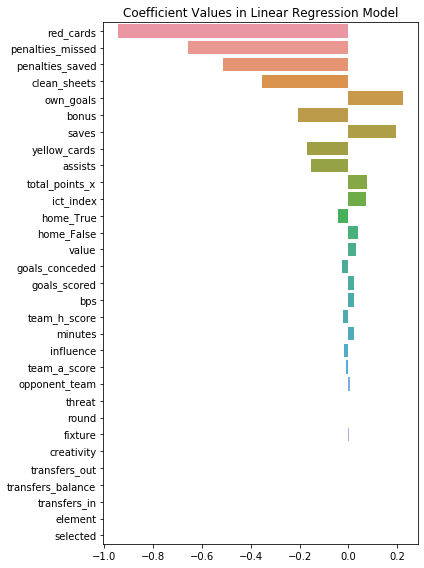

In [220]:
fi = sorted(list(zip(lr.coef_, X_train.columns)), key=lambda x:abs(x[0]), reverse=True)
plt.figure(figsize=(6,8))
sns.barplot([x[0] for x in fi], [x[1] for x in fi]) 
plt.title('Coefficient Values in Linear Regression Model')   
plt.tight_layout()
# plt.savefig('article_data/first/lr_coefficients.png')
plt.show()

### Section 3 - Predicting 2020-21 Week 2


Here I'm bringing in data for the first two weeks of this 2020/2021 season...

In [268]:
wk1 = pd.read_csv('../Fantasy-Premier-League/data/2020-21/gws/gw1.csv')
wk2 = pd.read_csv('../Fantasy-Premier-League/data/2020-21/gws/gw2.csv')

In [269]:
wk12 = pd.merge(wk1, wk2[['name', 'total_points']], on='name', how='inner') 

# get home/away dummies 
home_dummy = pd.get_dummies(wk12['was_home'], prefix='home') 
wk12 = pd.concat([wk12, home_dummy], axis=1).drop(['was_home', 'kickoff_time'], axis=1)

I'll call my multiple linear regression model and create a new column called "predicted points", as well as a column which simply checks if the model over/undervalued that observation

In [270]:
wk12['predicted points'] = lr.predict(wk12[X_train.columns])   
# add a column for over or undervalued 
wk12['Model Value'] = ['overvalued' if pred > actual else 'undervalued' for (actual, pred) in 
 zip(wk12['total_points_y'].values, wk12['predicted points'].values)]

Next, I'll take the same performance metrics as before 

In [286]:
mse_unseen = mean_squared_error(wk12['total_points_y'].values, wk12['predicted points'].values) 
mae_unseen = mean_absolute_error(wk12['total_points_y'].values, wk12['predicted points'].values)  
mse_base2 = mean_squared_error(wk12['total_points_y'].values, wk12['total_points_x'].values) 
mae_base2 = mean_absolute_error(wk12['total_points_y'].values, wk12['total_points_x'].values)

print("Model Performance \n-----")
print(f"MSE for Week 2 Predictions: \t{round(mse_unseen,3)}") 
print(f"MAE for Week 2 Predictions: \t{round(mae_unseen,3)}") 
print("\nBaseline Performance \n-----")
print(f"MSE for Week 2 Predictions: \t{round(mse_base2,3)}") 
print(f"MAE for Week 2 Predictions: \t{round(mae_base2,3)}") 

Model Performance 
-----
MSE for Week 2 Predictions: 	7.968
MAE for Week 2 Predictions: 	1.466

Baseline Performance 
-----
MSE for Week 2 Predictions: 	12.873
MAE for Week 2 Predictions: 	1.701


Although the model does perform less well on this new unseen data, it still predicts substantially better than a simple baseline of predicting week 1's points for week 2

Underneath we can visualize the predictions. It looks like there's a fairly balanced split between obersvations where the model overvalues and undervalues (compared to the actual scores) its predictions 

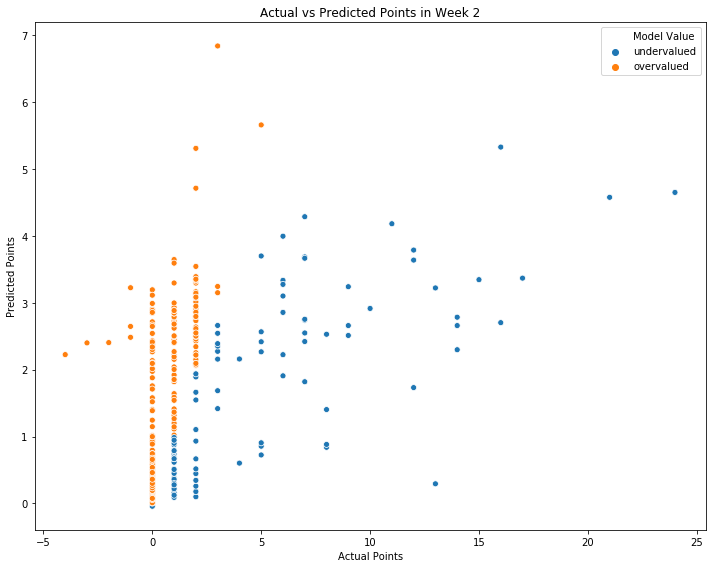

In [296]:
plt.figure(figsize=(10,8))
sns.scatterplot(wk12['total_points_y'], wk12['predicted points'], hue=wk12['Model Value'])    
plt.xlabel('Actual Points') 
plt.ylabel('Predicted Points') 
plt.title('Actual vs Predicted Points in Week 2') 
plt.tight_layout() 
# plt.savefig('article_data/first/wk2_predictions.png') 
plt.show()

### Outlook

All in all, the model does ok but leaves much room for improvement. Right now we're imposing a bias by restricting the hypothesis space to only linear models, but in the future this can and should be opened up to other models as well. We can also think about engineering some new features and/or finding new sources of data.

Some ideas for next time

---- 

- Cross Validation 
- Tree-Based Models 
- Feature Engineering 
   - Team streak 
   - Opp difficulty  
- Longer Prediction window